# SI608 Project
### Samantha Fischer and Caitlin O'Grady

In [ ]:
import pandas as pd
import networkx as nx
import numpy as np
from networkx.algorithms import community
import matplotlib.pyplot as plt
import random
import requests
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import classification_report

### Generate Dataframe of Player Data

In [ ]:
players = pd.read_csv('nfl_draft.csv')
#clean the dataframe, separate name and year
players = players.rename(columns={'column_a':'name'})
players[['year', 'player_name']] = players['name'].str.extract(r'(\d{4})([A-Za-z ]+)')
players = players.drop(columns=['name'])
#simplify dataframe, only get the columns we are going to use
players = players[['player_name', 'year', 'rnd', 'pick', 'tm', 'pos', 'college_univ']]
# it seems that the abbreviations they used are not standardized, I manually matched them and used this dictionary to add team names
abbrevs = {
    'TAM': 'Tampa Bay Buccaneers',
    'TEN': 'Tennessee Titans',
    'JAX': 'Jacksonville Jaguars',
    'OAK': 'Las Vegas Raiders',  #OAK used to be the Oakland Raiders, they moved to LV in 2020 but for the sake of consistency, OAK will be changed to LV raiders
    'WAS': 'Washington Commanders',
    'NYJ': 'New York Jets',
    'CHI': 'Chicago Bears',
    'ATL': 'Atlanta Falcons',
    'NYG': 'New York Giants',
    'STL': 'Los Angeles Rams',  #STL Rams changed to LA Rams, for continuity updating all
    'MIN': 'Minnesota Vikings',
    'CLE': 'Cleveland Browns',
    'NOR': 'New Orleans Saints',
    'MIA': 'Miami Dolphins',
    'SDG': 'Los Angeles Chargers',  #SDG chargers moved to LA, updating all for sake of continuity
    'HOU': 'Houston Texans',
    'SFO': 'San Francisco 49ers',
    'KAN': 'Kansas City Chiefs',
    'PHI': 'Philadelphia Eagles',
    'CIN': 'Cincinnati Bengals',
    'PIT': 'Pittsburgh Steelers',
    'DEN': 'Denver Broncos',
    'ARI': 'Arizona Cardinals',
    'CAR': 'Carolina Panthers',
    'BAL': 'Baltimore Ravens',
    'DAL': 'Dallas Cowboys',
    'DET': 'Detroit Lions',
    'IND': 'Indianapolis Colts',
    'GNB': 'Green Bay Packers',
    'NWE': 'New England Patriots',
    'BUF': 'Buffalo Bills',
    'SEA': 'Seattle Seahawks',
    'RAM': 'Los Angeles Rams',
    'RAI': 'Las Vegas Raiders',
    'PHO': 'Arizona Cardinals'
}
players.loc[:, 'nfl_team'] = players['tm'].map(abbrevs)

# Drop NA values (there were about 3,400 NA values for college)
players = players.dropna()

players.head()

,player_name,year,rnd,pick,tm,pos,college_univ,nfl_team
0,Jameis Winston,2015,1,1,TAM,QB,Florida St.,Tampa Bay Buccaneers
1,Marcus Mariota,2015,1,2,TEN,QB,Oregon,Tennessee Titans
2,Dante Fowler,2015,1,3,JAX,OLB,Florida,Jacksonville Jaguars
3,Amari Cooper,2015,1,4,OAK,WR,Alabama,Las Vegas Raiders
4,Brandon Scherff,2015,1,5,WAS,T,Iowa,Washington Commanders


### Generate Dataframe of NFL Teams

In [ ]:
teams = pd.read_csv('nfl_teams.csv')
#reorder the dictionary from above, so can map the names in this dataframe to the abbreviations from above
#just for continuity sake / to not be confusing later on down the line
abbrev_rev = {name: abbrev for abbrev, name in abbrevs.items()}
teams.loc[:, 'Abbreviation'] = teams['Name'].map(abbrev_rev)
teams.head()

,ID,Name,Abbreviation,Conference,Division
0,1,Arizona Cardinals,PHO,NFC,West
1,2,Atlanta Falcons,ATL,NFC,South
2,3,Baltimore Ravens,BAL,AFC,North
3,4,Buffalo Bills,BUF,AFC,East
4,5,Carolina Panthers,CAR,NFC,South


### Generate Dataframe of College Teams

In [ ]:
college = pd.read_csv('cfb13.csv')
#only using the Team Column
college = college[['Team']]
#splitting the column into the team name and the conference
college[['Team', 'Conference']] = college['Team'].str.extract(r'(.+) \((.+)\)')
college.head()


,Team,Conference
0,Akron,MAC
1,Alabama,SEC
2,Arizona,Pac-12
3,Arizona St.,Pac-12
4,Arkansas,SEC


In [ ]:
# Combine into one dataset
# Combine three datasets (college, teams, players) into one dataframe
combined1_df = pd.merge(players, teams, left_on='nfl_team', right_on='Name', how='outer')
combined_df = pd.merge(combined1_df, college, left_on='college_univ', right_on='Team', how='outer')

# Dropping NAs
combined_df = combined_df.dropna()

combined_df.head()


,player_name,year,rnd,pick,tm,pos,college_univ,nfl_team,ID,Name,Abbreviation,Conference_x,Division,Team,Conference_y
6,Reggie Corner,2008,4.0,114.0,BUF,DB,Akron,Buffalo Bills,4.0,Buffalo Bills,BUF,AFC,East,Akron,MAC
7,Charlie Frye,2005,3.0,67.0,CLE,QB,Akron,Cleveland Browns,8.0,Cleveland Browns,CLE,AFC,North,Akron,MAC
8,Domenik Hixon,2006,4.0,130.0,DEN,WR,Akron,Denver Broncos,10.0,Denver Broncos,DEN,AFC,West,Akron,MAC
9,Jason Taylor,1997,3.0,73.0,MIA,DE,Akron,Miami Dolphins,17.0,Miami Dolphins,MIA,AFC,East,Akron,MAC
10,Andy Alleman,2007,3.0,88.0,NOR,G,Akron,New Orleans Saints,20.0,New Orleans Saints,NOR,NFC,South,Akron,MAC


# Creating and Displaying Network

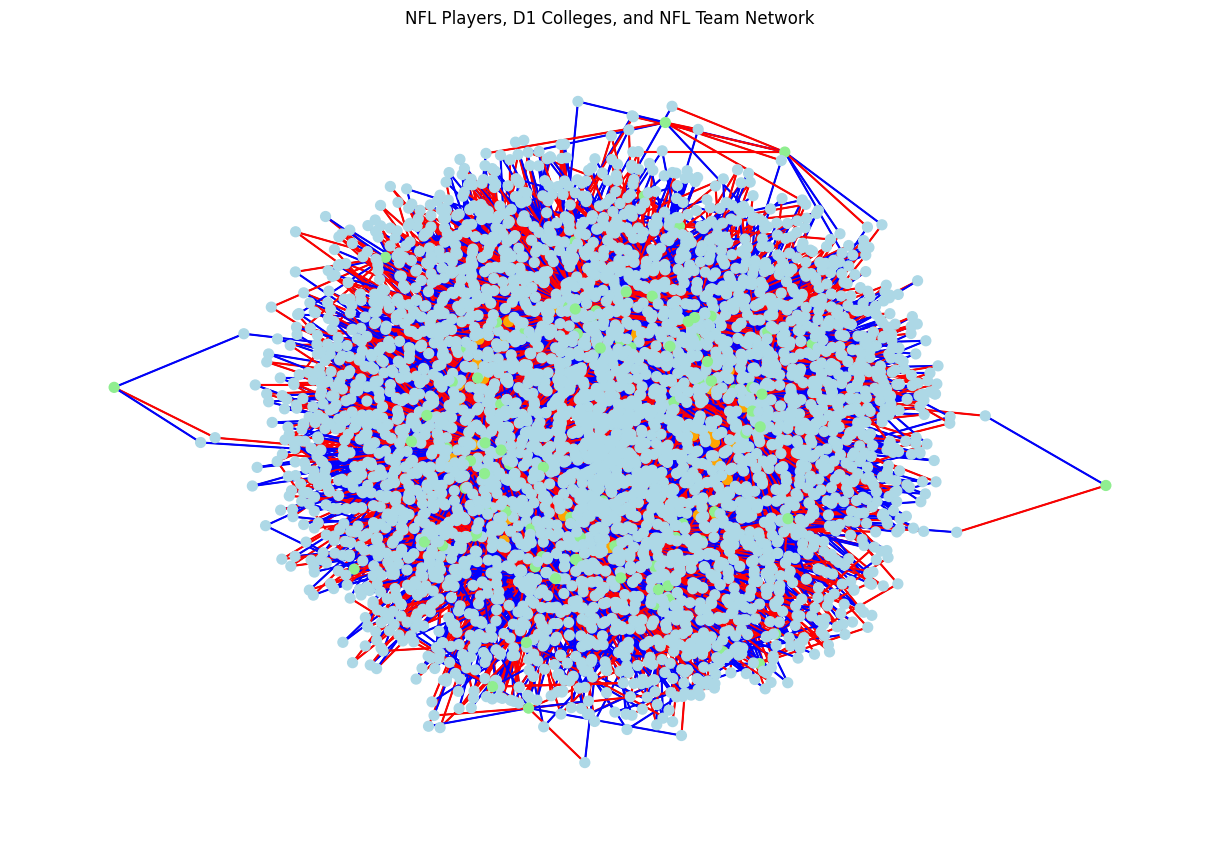

In [ ]:

G = nx.Graph()
edge_colors = []

for index, row in combined_df.iterrows():
    player = row['player_name']
    college = row['college_univ']
    nfl_team = row['nfl_team']
    draft_round = row['rnd']

    # inverse draft round, more weight for an earlier round
    weight = 1 / draft_round if draft_round != 0 else 0
    #add nodes
    G.add_node(player, node_type='player')
    G.add_node(college, node_type='college')
    G.add_node(nfl_team, node_type='team')

    #add edges with weight, differentiating color if connected with college vs NFL team
    G.add_edge(player, college, weight=weight)
    edge_colors.append('blue')
    G.add_edge(player, nfl_team, weight=weight)
    edge_colors.append('red')

#differentiate node color based on type
color_map = []
for node in G.nodes(data=True):
    if node[1]['node_type'] == 'player':
        color_map.append('lightblue')
    elif node[1]['node_type'] == 'college':
        color_map.append('lightgreen')
    elif node[1]['node_type'] == 'team':
        color_map.append('orange')

#visualize
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)

nx.draw(G, pos, node_color=color_map, with_labels=False, node_size=50, font_size=10)
nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=1.5)

plt.title('NFL Players, D1 Colleges, and NFL Team Network')
plt.show()


# Analysis of network

In [ ]:

for college in combined_df['college_univ'].unique():
    if college not in G:
        G.add_node(college, node_type='college')

    for nfl_team in combined_df['nfl_team'].unique():
        #count number of alumni for each college and adds it to the node
        alumni_count = len(combined_df[(combined_df['college_univ'] == college) & (combined_df['nfl_team'] == nfl_team)])
        G.nodes[college]['alumni_in_team_' + nfl_team] = alumni_count

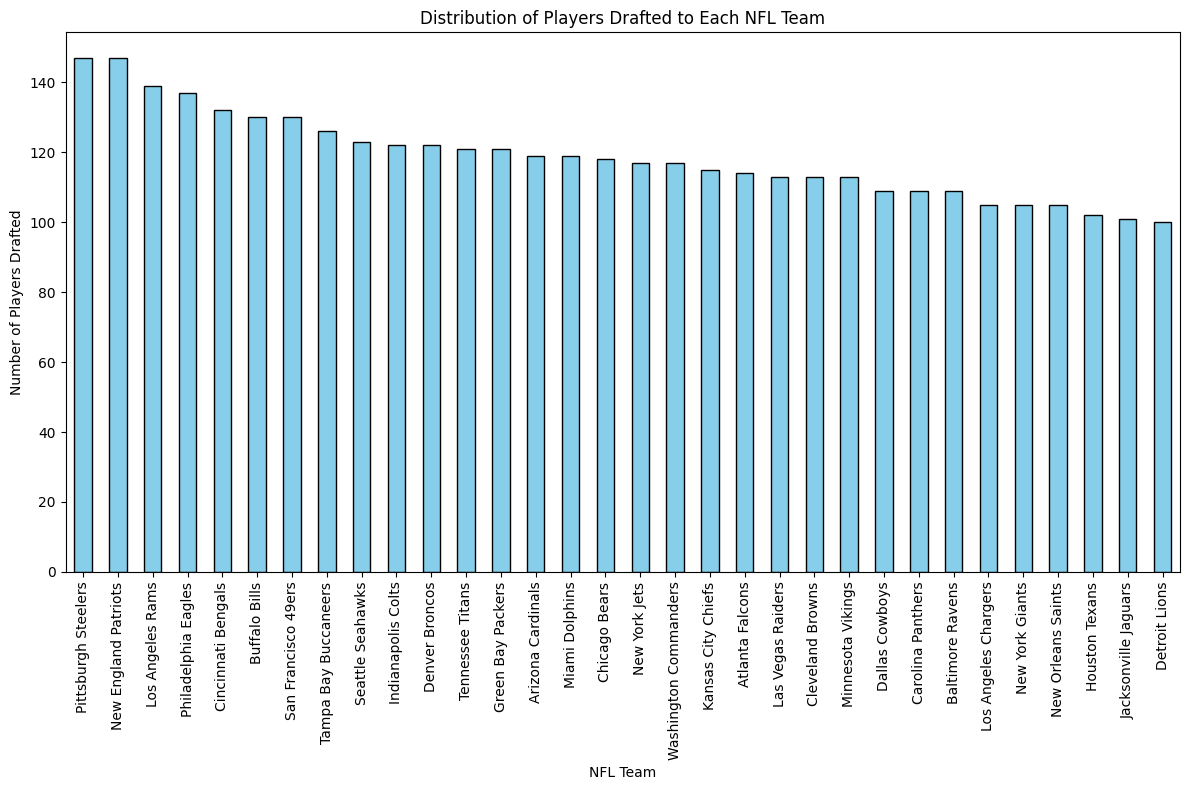

In [ ]:
#bar chart of the players drafted to each NFL team
team_counts = combined_df['nfl_team'].value_counts()

plt.figure(figsize=(12, 8))
team_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribution of Players Drafted to Each NFL Team')
plt.xlabel('NFL Team')
plt.ylabel('Number of Players Drafted')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

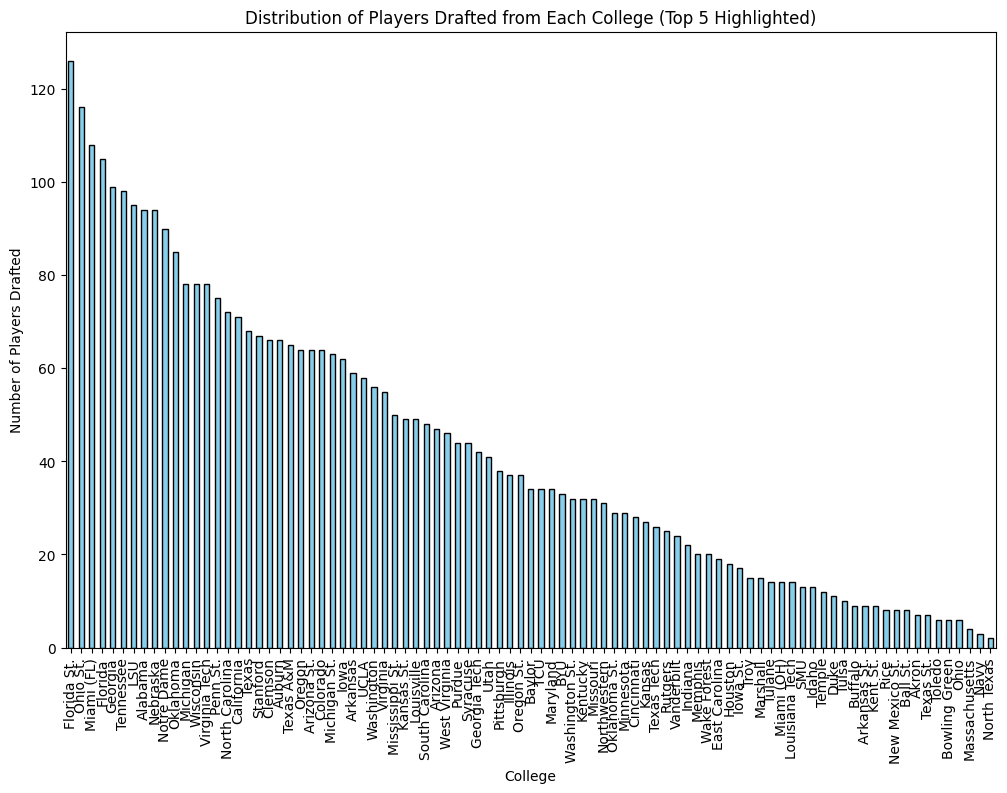

Top 5 Colleges with the Most Drafted Players:
college_univ
Florida St.    126
Ohio St.       116
Miami (FL)     108
Florida        105
Georgia         99
Name: count, dtype: int64


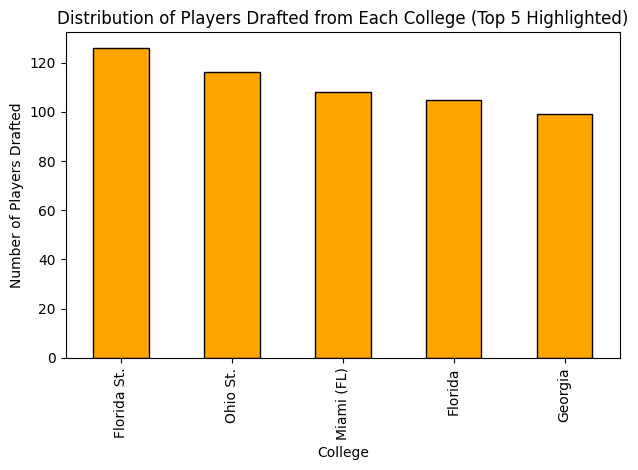

In [ ]:
#number of players drafted from each college
college_counts = combined_df['college_univ'].value_counts()
top_5_colleges = college_counts.head(5)
plt.figure(figsize=(12, 8))
college_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.title('Distribution of Players Drafted from Each College (Top 5 Highlighted)')
plt.xlabel('College')
plt.ylabel('Number of Players Drafted')
plt.show()

#top 5 colleges with the most players drafted
top_5_colleges.plot(kind='bar', color='orange', edgecolor='black')

plt.title('Distribution of Players Drafted from Each College (Top 5 Highlighted)')
plt.xlabel('College')
plt.ylabel('Number of Players Drafted')
plt.xticks(rotation=90)

print("Top 5 Colleges with the Most Drafted Players:")
print(top_5_colleges)

plt.tight_layout()
plt.show()


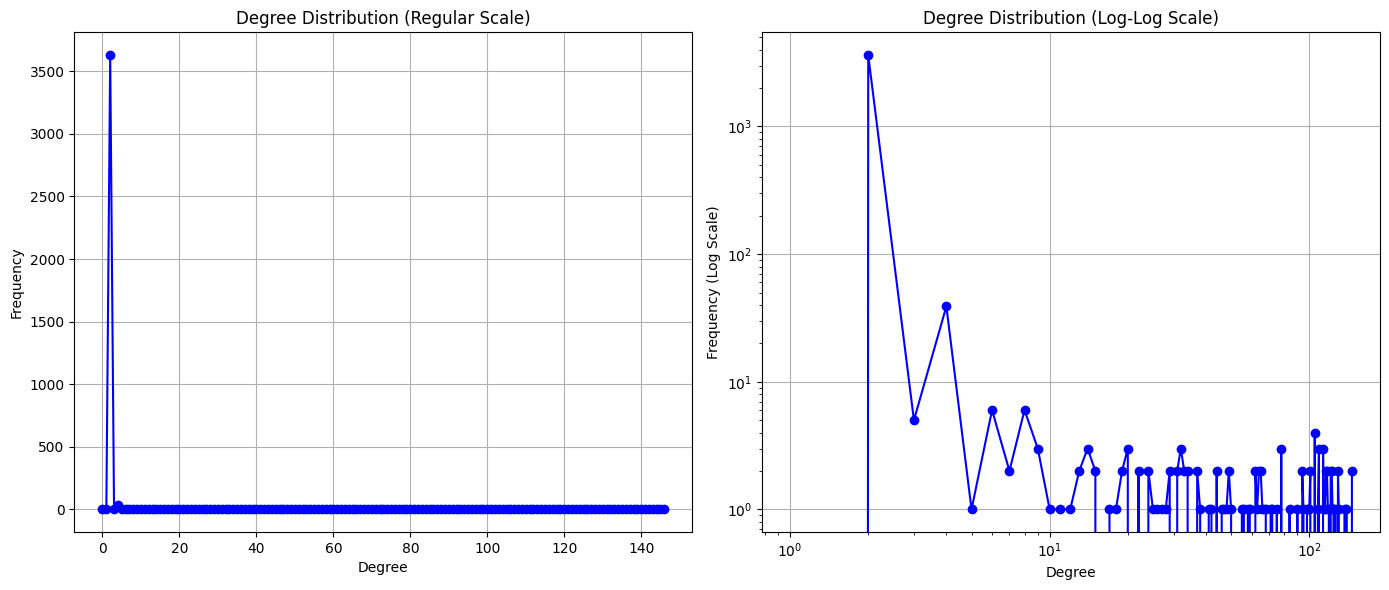

In [ ]:
# find the degree distribution for the network
degrees = [deg for _, deg in G.degree()]
degree_counts = np.bincount(degrees)
degree_range = np.arange(len(degree_counts))

#plot degree distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(degree_range, degree_counts, 'bo-')
ax1.set_title("Degree Distribution (Regular Scale)")
ax1.set_xlabel("Degree")
ax1.set_ylabel("Frequency")
ax1.grid(True)

#plot degree distribution on log log scale
ax2.plot(degree_range, degree_counts, 'bo-')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title("Degree Distribution (Log-Log Scale)")
ax2.set_xlabel("Degree")
ax2.set_ylabel("Frequency (Log Scale)")
ax2.grid(True)

plt.tight_layout()
plt.show()



# Centrality Analysis

In [ ]:
#calculate
betweenness_centrality = nx.betweenness_centrality(G)
degree_centrality = nx.degree_centrality(G)

#separate nodes by type
college_nodes = [node for node, data in G.nodes(data=True) if data['node_type'] == 'college']
player_nodes = [node for node, data in G.nodes(data=True) if data['node_type'] == 'player']
team_nodes = [node for node, data in G.nodes(data=True) if data['node_type'] == 'team']

#filter and sort nodes by top centrality score
def get_top_centrality_nodes(nodes, centrality_dict, top_n=5):
    filtered_centrality = {node: centrality_dict[node] for node in nodes}
    sorted_centrality = sorted(filtered_centrality.items(), key=lambda x: x[1], reverse=True)
    return sorted_centrality[:top_n]

#top 5 betweenness for each type
top_betweenness_colleges = get_top_centrality_nodes(college_nodes, betweenness_centrality)
top_betweenness_players = get_top_centrality_nodes(player_nodes, betweenness_centrality)
top_betweenness_teams = get_top_centrality_nodes(team_nodes, betweenness_centrality)

#top 5 degree cent. for each type
top_degree_colleges = get_top_centrality_nodes(college_nodes, degree_centrality)
top_degree_players = get_top_centrality_nodes(player_nodes, degree_centrality)
top_degree_teams = get_top_centrality_nodes(team_nodes, degree_centrality)

#results
print("Top 5 Colleges by Betweenness Centrality:")
for node, centrality in top_betweenness_colleges:
    print(f"College: {node}, Betweenness Centrality: {centrality}")

print("\nTop 5 Players by Betweenness Centrality:")
for node, centrality in top_betweenness_players:
    print(f"Player: {node}, Betweenness Centrality: {centrality}")

print("\nTop 5 NFL Teams by Betweenness Centrality:")
for node, centrality in top_betweenness_teams:
    print(f"Team: {node}, Betweenness Centrality: {centrality}")

print("\nTop 5 Colleges by Degree Centrality:")
for node, centrality in top_degree_colleges:
    print(f"College: {node}, Degree Centrality: {centrality}")

print("\nTop 5 Players by Degree Centrality:")
for node, centrality in top_degree_players:
    print(f"Player: {node}, Degree Centrality: {centrality}")

print("\nTop 5 NFL Teams by Degree Centrality:")
for node, centrality in top_degree_teams:
    print(f"Team: {node}, Degree Centrality: {centrality}")


Top 5 Colleges by Betweenness Centrality:
College: Florida St., Betweenness Centrality: 0.039063527792747015
College: Ohio St., Betweenness Centrality: 0.03465596297957439
College: Miami (FL), Betweenness Centrality: 0.03419315166401871
College: Alabama, Betweenness Centrality: 0.029975112608191763
College: Florida, Betweenness Centrality: 0.02947901342095389

Top 5 Players by Betweenness Centrality:
Player: D, Betweenness Centrality: 0.08257734364137058
Player: J, Betweenness Centrality: 0.05626738093304598
Player: A, Betweenness Centrality: 0.04083652026983321
Player: T, Betweenness Centrality: 0.03498172139213866
Player: C, Betweenness Centrality: 0.030457182763744362

Top 5 NFL Teams by Betweenness Centrality:
Team: New England Patriots, Betweenness Centrality: 0.04658237761964109
Team: Los Angeles Rams, Betweenness Centrality: 0.04334889044214619
Team: Pittsburgh Steelers, Betweenness Centrality: 0.04009152563116121
Team: Philadelphia Eagles, Betweenness Centrality: 0.039437103090

# Community Detection

In [ ]:
#community detection
#reformat nodes and weight
G = nx.relabel_nodes(G, {n: str(n) for n in G.nodes()})
for u, v, data in G.edges(data=True):
    if 'weight' in data:
        data['weight'] = float(data['weight'])
communities = community.greedy_modularity_communities(G)
for i, comm in enumerate(communities):
    print(f"Community {i+1}: {comm}")

Community 1: frozenset({'Derrius Monroe', 'DeLawrence Grant', 'Corey Webster', 'Bobby Shaw', 'Todd McClure', 'Bill Swancutt', 'Michael Brockers', 'Thomas Brown', 'Chad Lavalais', 'James Allen', 'Kenny Hilliard', 'Martrez Milner', 'Brandon Tolbert', 'Kwon Alexander', 'Jalen Collins', 'Chris Terry', 'Charles Scott', 'Adimchinobe Echemandu', 'Glenn Dorsey', 'Chevis Jackson', 'Adrian McPherson', 'Henry Lusk', 'Brandon Boykin', 'Charles Grant', 'Damian Swann', 'Richard Seigler', 'Bennie Logan', 'Dameian Jeffries', 'Skyler Green', 'David Greene', 'Claude Wroten', 'Brandon Winey', 'Georgia', 'Lamin Barrow', 'Jordan Poyer', 'Atlanta Falcons', 'Jack Williams', 'Marquise Hill', 'Kris Durham', 'Trai Turner', 'Matt Flynn', 'Gabe Miller', 'Barkevious Mingo', 'Brandon Mebane', 'Dri Archer', 'DeAngelo Tyson', 'Chester Adams', 'Patrick Peterson', 'JaMarcus Russell', 'DeMario Minter', 'Eric Zeier', 'Antonio Fleming', 'Devery Henderson', 'Michael Clayton', 'Adam Koets', 'Amarlo Herrera', 'Keith Zinger',

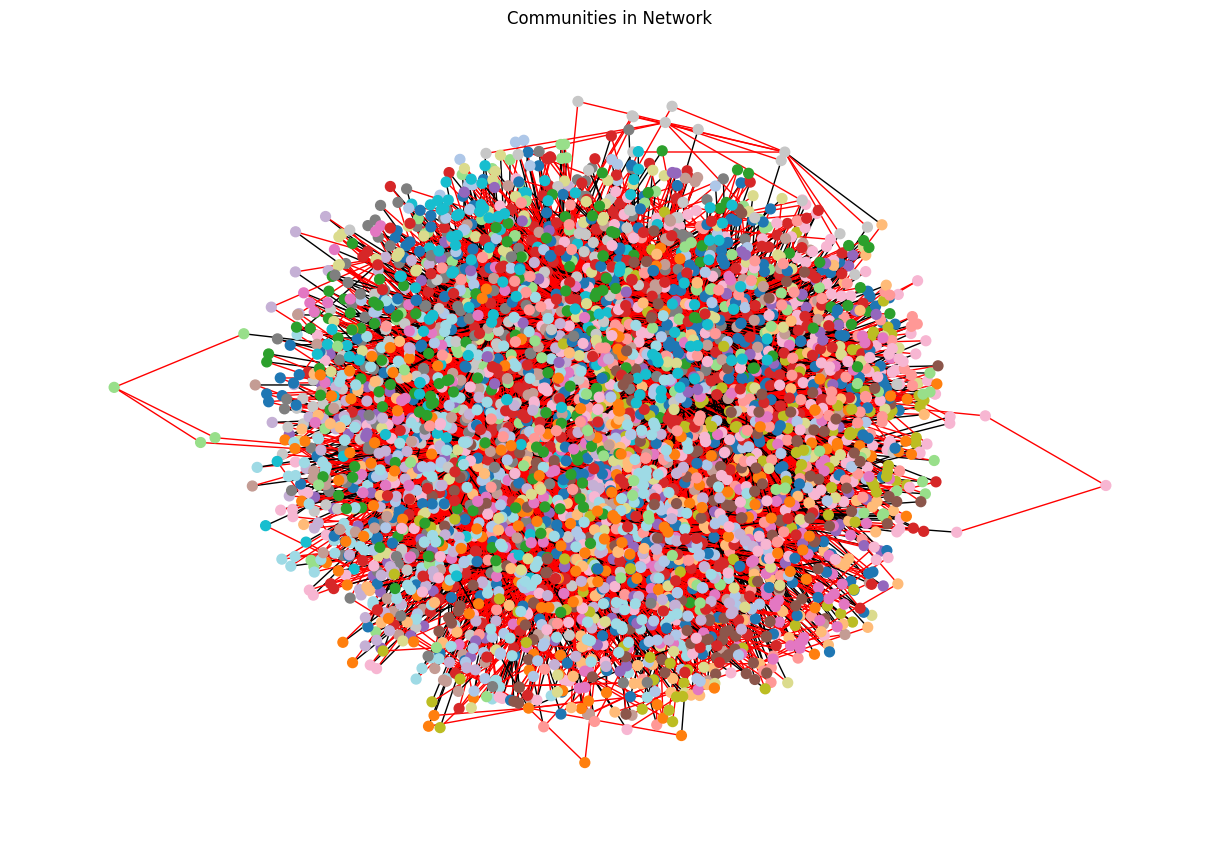

In [ ]:
# Map each node to its community
community_assignments = {}
for i, comm in enumerate(communities):
    for node in comm:
        community_assignments[node] = i

# Give edges colors
intra_colors = ['red' if community_assignments[u] == community_assignments[v] else 'black'
                for u, v in G.edges]

community_colors = [community_assignments[node] for node in G.nodes]

plt.figure(figsize=(12, 8))
nx.draw(G, pos, node_color=community_colors, edge_color=intra_colors, with_labels=False, cmap=plt.cm.tab20, node_size=50)
plt.title('Communities in Network')
plt.show()

# Pagerank

In [ ]:
#pagerank and centrality
college_pagerank = nx.pagerank(G)
college_centrality = nx.degree_centrality(G)
#add scores to df
combined_df['pagerank'] = combined_df['college_univ'].map(college_pagerank)
combined_df['centrality'] = combined_df['college_univ'].map(college_centrality)

In [ ]:
college_pagerank = combined_df[['college_univ', 'pagerank']].drop_duplicates().sort_values(by='pagerank', ascending=False)
print("PageRank values for each college:")
print(college_pagerank.head(50))


PageRank values for each college:
         college_univ  pagerank
1119      Florida St.  0.008608
3024         Ohio St.  0.007825
2106       Miami (FL)  0.007665
991           Florida  0.007130
3964        Tennessee  0.006429
1828              LSU  0.006363
24            Alabama  0.006325
1298          Georgia  0.005892
2573         Nebraska  0.005495
2928       Notre Dame  0.005401
3140         Oklahoma  0.005247
2228         Michigan  0.005207
4927        Wisconsin  0.004943
4074            Texas  0.004848
3357         Penn St.  0.004623
2730   North Carolina  0.004603
578        California  0.004457
4640    Virginia Tech  0.004441
334            Auburn  0.004371
4142        Texas A&M  0.004135
728           Clemson  0.004053
3254           Oregon  0.003882
4324             UCLA  0.003760
799          Colorado  0.003721
192       Arizona St.  0.003705
1603             Iowa  0.003695
4741       Washington  0.003688
3797         Stanford  0.003559
2306     Michigan St.  0.003444
261   

# Predictive Model

In [ ]:
#features to be used for model
degree_centrality = nx.degree_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
pagerank = nx.pagerank(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

#filter measures for only players
player_nodes = set(combined_df['player_name'])
degree_centrality = {k: v for k, v in degree_centrality.items() if k in player_nodes}
closeness_centrality = {k: v for k, v in closeness_centrality.items() if k in player_nodes}
betweenness_centrality = {k: v for k, v in betweenness_centrality.items() if k in player_nodes}
pagerank = {k: v for k, v in pagerank.items() if k in player_nodes}
eigenvector_centrality = {k: v for k, v in eigenvector_centrality.items() if k in player_nodes}

#assign features to the dataframe
combined_df['degree_centrality'] = combined_df['player_name'].map(degree_centrality)
combined_df['closeness_centrality'] = combined_df['player_name'].map(closeness_centrality)
combined_df['betweenness_centrality'] = combined_df['player_name'].map(betweenness_centrality)
combined_df['pagerank'] = combined_df['player_name'].map(pagerank)
combined_df['eigenvector_centrality'] = combined_df['player_name'].map(eigenvector_centrality)

#add community membership as feature in df
communities = community.greedy_modularity_communities(G)
community_map = {}
for i, community_nodes in enumerate(communities):
    for node in community_nodes:
        community_map[node] = i
community_map = {k: v for k, v in community_map.items() if k in player_nodes}
combined_df['community'] = combined_df['player_name'].map(community_map)

#encode nfl teams
le = LabelEncoder()
combined_df['nfl_team_encoded'] = le.fit_transform(combined_df['nfl_team'])

#add alumni count to the df
alumni_counts = combined_df.groupby(['college_univ', 'nfl_team', 'player_name']).size().reset_index(name='alumni_count')
alumni_counts['alumni_excluding_current'] = (
    alumni_counts.groupby(['college_univ', 'nfl_team'])['alumni_count'].transform('sum') - alumni_counts['alumni_count']
)
combined_df = combined_df.merge(
    alumni_counts[['college_univ', 'nfl_team', 'player_name', 'alumni_excluding_current']],
    on=['college_univ', 'nfl_team', 'player_name'], how='left'
)
combined_df['total_alumni'] = combined_df.groupby('college_univ')['player_name'].transform('count')

#add second order connections as feature
second_order_connections = {
    node: sum(len(set(G.neighbors(neighbor))) for neighbor in G.neighbors(node))
    for node in player_nodes
}
combined_df['second_order_connections'] = combined_df['player_name'].map(second_order_connections)

#separate columns
X = combined_df[['degree_centrality', 'closeness_centrality', 'community', 'pagerank',
                 'betweenness_centrality', 'total_alumni', 'eigenvector_centrality', 'second_order_connections']]
y = combined_df['nfl_team_encoded']

#train model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42, class_weight='balanced')
model.fit(X_train, y_train)

#make predictions
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

#map the team names back to encoded labels
predicted_team_names = le.inverse_transform(y_pred)


test_indices = X_test.index
player_names = combined_df.loc[test_indices, 'player_name']

#results
results_df = pd.DataFrame({
    'player_name': player_names,
    'predicted_team': predicted_team_names
})

display(results_df)


              precision    recall  f1-score   support

           0       0.86      0.79      0.83        24
           1       0.74      0.68      0.71        25
           2       0.83      0.79      0.81        24
           3       0.66      0.91      0.76        23
           4       0.87      0.76      0.81        17
           5       0.52      0.81      0.63        21
           6       0.76      0.79      0.78        24
           7       0.77      0.94      0.85        18
           8       0.53      0.64      0.58        14
           9       0.66      0.84      0.74        25
          10       0.90      0.90      0.90        21
          11       0.91      0.75      0.82        28
          12       0.67      0.70      0.68        20
          13       0.81      0.76      0.79        29
          14       0.74      0.67      0.70        21
          15       0.75      0.75      0.75        24
          16       0.81      0.71      0.76        31
          17       0.75    

,player_name,predicted_team
1003,Jeff Owens,Philadelphia Eagles
594,Coty Sensabaugh,Tennessee Titans
461,Eric Mahlum,Indianapolis Colts
3018,Montario Hardesty,Minnesota Vikings
3091,Justin Hunter,Tennessee Titans
...,...,...
1228,Tim Kohn,Las Vegas Raiders
2480,Justin Blackmon,Cleveland Browns
2004,Adam Carriker,Los Angeles Rams
3022,Al Wilson,Denver Broncos


In [ ]:
# Listing out teams by number for context
team_mapping = {index: team for index, team in enumerate(le.classes_)}

for label, team in team_mapping.items():
    print(f"Label {label}: {team}")


Label 0: Arizona Cardinals
Label 1: Atlanta Falcons
Label 2: Baltimore Ravens
Label 3: Buffalo Bills
Label 4: Carolina Panthers
Label 5: Chicago Bears
Label 6: Cincinnati Bengals
Label 7: Cleveland Browns
Label 8: Dallas Cowboys
Label 9: Denver Broncos
Label 10: Detroit Lions
Label 11: Green Bay Packers
Label 12: Houston Texans
Label 13: Indianapolis Colts
Label 14: Jacksonville Jaguars
Label 15: Kansas City Chiefs
Label 16: Las Vegas Raiders
Label 17: Los Angeles Chargers
Label 18: Los Angeles Rams
Label 19: Miami Dolphins
Label 20: Minnesota Vikings
Label 21: New England Patriots
Label 22: New Orleans Saints
Label 23: New York Giants
Label 24: New York Jets
Label 25: Philadelphia Eagles
Label 26: Pittsburgh Steelers
Label 27: San Francisco 49ers
Label 28: Seattle Seahawks
Label 29: Tampa Bay Buccaneers
Label 30: Tennessee Titans
Label 31: Washington Commanders


# Understand Model

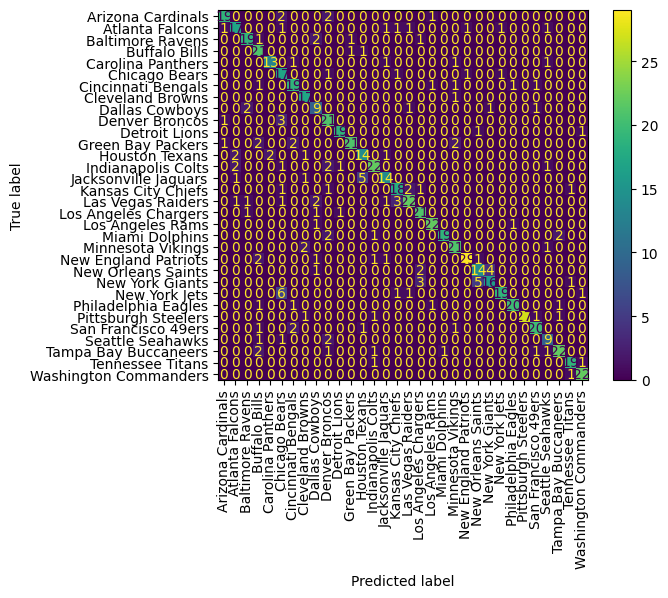

In [ ]:
#confusion matrix between actual values and predicted values
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='viridis', xticks_rotation=90)
plt.show()

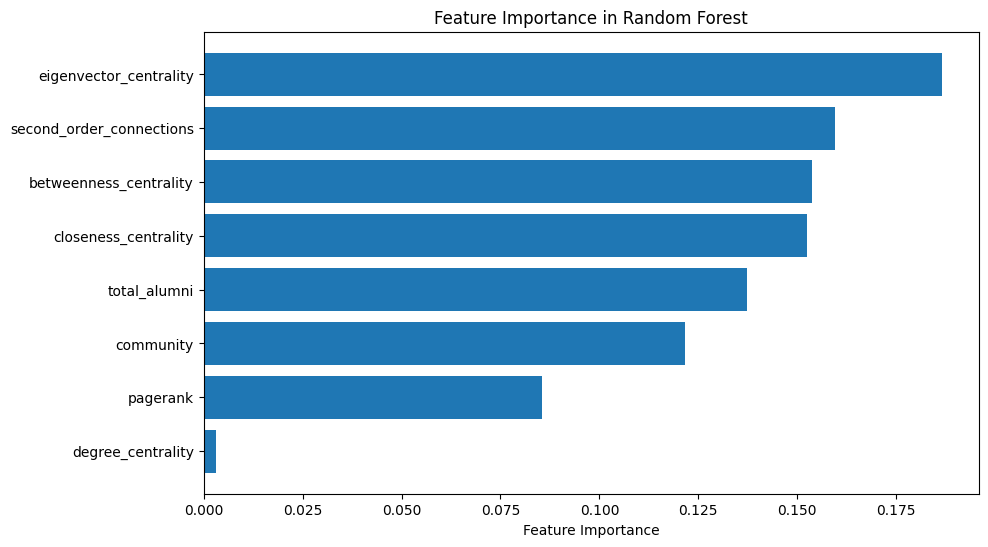

In [ ]:
#look at the importance of each feature in the model
importances = model.feature_importances_
features = X.columns
indices = importances.argsort()

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Feature Importance')
plt.title('Feature Importance in Random Forest')
plt.show()

# Possibilities for Future Analysis


In [ ]:
#look at cosine similarity between positions by team
position_counts = combined_df.groupby(['nfl_team', 'pos']).size().unstack(fill_value=0)
cosine_sim_positions = cosine_similarity(position_counts)
cosine_sim_positions_df = pd.DataFrame(cosine_sim_positions, index=position_counts.index, columns=position_counts.index)
print(cosine_sim_positions_df)


nfl_team               Arizona Cardinals  Atlanta Falcons  Baltimore Ravens  \
nfl_team                                                                      
Arizona Cardinals               1.000000         0.958578          0.947913   
Atlanta Falcons                 0.958578         1.000000          0.973082   
Baltimore Ravens                0.947913         0.973082          1.000000   
Buffalo Bills                   0.907079         0.955474          0.949409   
Carolina Panthers               0.952510         0.966422          0.973807   
Chicago Bears                   0.935259         0.954241          0.980477   
Cincinnati Bengals              0.942307         0.956380          0.989883   
Cleveland Browns                0.927068         0.956064          0.982314   
Dallas Cowboys                  0.945823         0.963549          0.936421   
Denver Broncos                  0.926675         0.976686          0.964230   
Detroit Lions                   0.951579         0.9

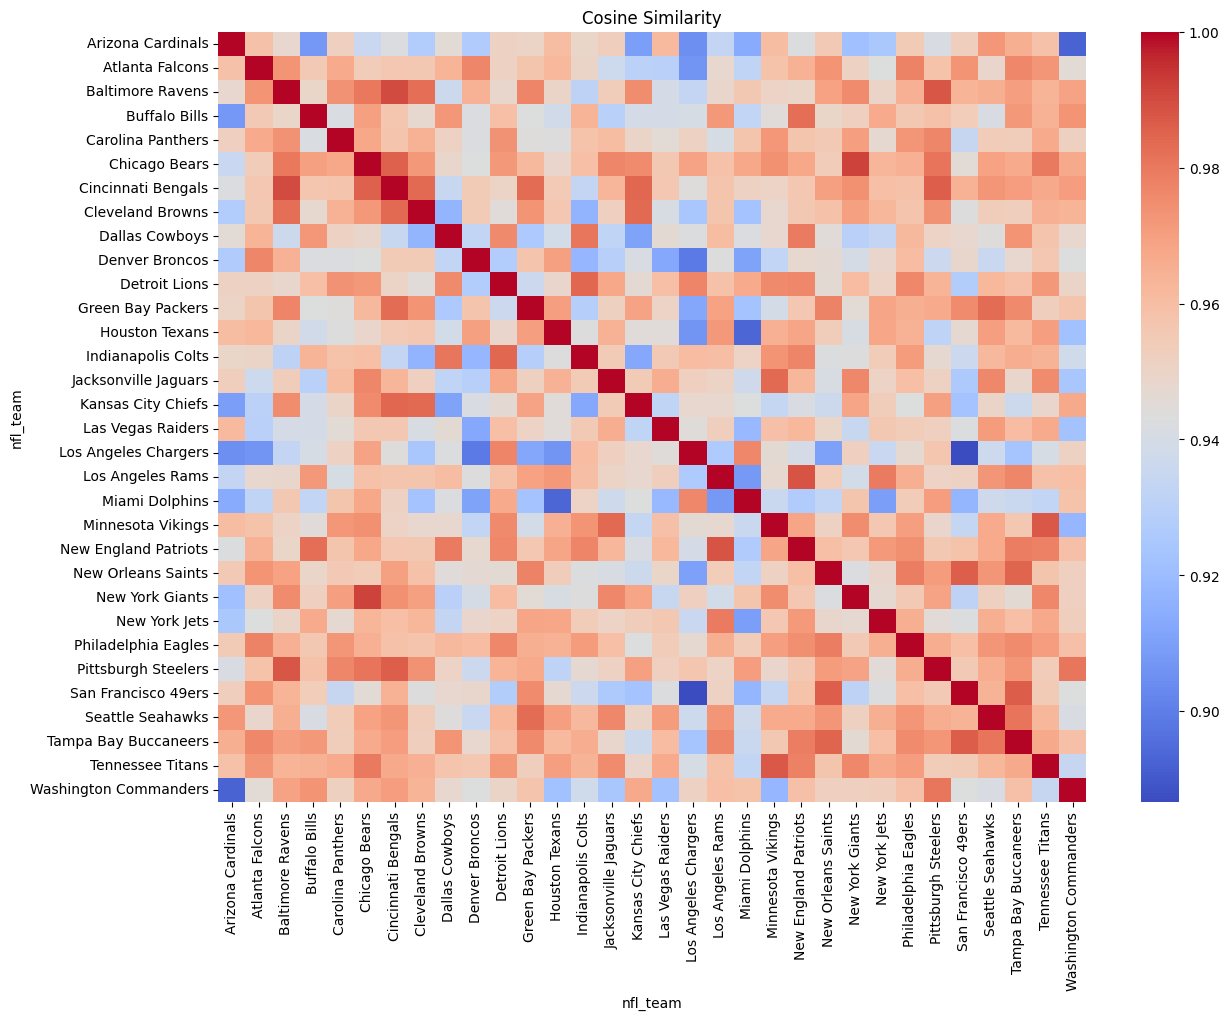

In [ ]:
#heatmap of cosine similarity
plt.figure(figsize=(14, 10))
sns.heatmap(cosine_sim_positions_df, annot=False, cmap='coolwarm', fmt='.2f')
plt.title('Cosine Similarity')
plt.show()


In [ ]:
#cosine similarities between positions
position_counts = combined_df.groupby(['nfl_team', 'pos']).size().unstack(fill_value=0)
cosine_sim_positions = cosine_similarity(position_counts)
cosine_sim_positions_df = pd.DataFrame(cosine_sim_positions, index=position_counts.index, columns=position_counts.index)
cosine_sim_pairs = cosine_sim_positions_df.stack()
top_teams = cosine_sim_pairs.sort_values(ascending=False).head(40)
display(top_teams)

,,0
nfl_team,nfl_team,
Washington Commanders,Washington Commanders,1.000000
Dallas Cowboys,Dallas Cowboys,1.000000
Cleveland Browns,Cleveland Browns,1.000000
Minnesota Vikings,Minnesota Vikings,1.000000
Baltimore Ravens,Baltimore Ravens,1.000000
San Francisco 49ers,San Francisco 49ers,1.000000
Pittsburgh Steelers,Pittsburgh Steelers,1.000000
Philadelphia Eagles,Philadelphia Eagles,1.000000
New York Jets,New York Jets,1.000000
